In [4]:
# @title importações e bases - Rodar primeiro
#Importando as bibliotecas

from datetime import date
from datetime import timedelta
from datetime import timedelta, time
import pandas as pd
import numpy as np

#Ajustando as colunas conforme o documento - o tasy não cria as colunas de forma que seja possível ler em python, é necessário criar manualmente.
#copiar as colunas do documento txt e criar a lista a seguir, sem essa etapa o arquivo csv não vai criar as colunas.

columns = ['Nr atendimento',	'Setor paciente',	'Setor prescricao',	'Ds local estoque',	'Cd material',	'Ds material',	'Nr sequencia',	'Dt prescricao',	'Dt entrega setor',	'Dt recebimento setor',	'Dt geracao lote',	'Ds classificacao',	'Dt ger lote',	'Hr ger lote',	'Dt entr setor',	'Hr entr setor',	'Usuario entrega']

#Ajustando os tipos de dados das colunas conforme o documento
#Facilita deixar cada coluna em uma linha, para ajustar a visualização dos tipos de dados - datas precisam estar como str (será convertido depois).

tipos_dados = {
    'Nr atendimento': str,
    'Setor paciente': str,
    'Setor prescricao': str,
    'Ds local estoque': str,
    'Cd material': str,
    'Ds material': str,
    'Nr sequencia': str,
    'Dt prescricao': str,
    'Dt entrega setor': str,
    'Dt recebimento setor': str,
    'Dt geracao lote': str,
    'Ds classificacao': str,
    'Dt ger lote': str,
    'Hr ger lote': str,
    'Dt entr setor': str,
    'Hr entr setor': str,
    'Usuario entrega': str}

In [5]:
from google.colab import drive
drive.mount('/content/drive')

tempos_bruto0 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Análise do tempo de entregas/Outubro/outubro.csv', delimiter=';', names=columns, dtype=tipos_dados, engine='python', encoding='utf-8')
tempos_bruto1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Análise do tempo de entregas/Outubro/17.csv', delimiter=';', names=columns, dtype=tipos_dados, engine='python', encoding='utf-8')
tempos_bruto = pd.concat([tempos_bruto0, tempos_bruto1], ignore_index=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


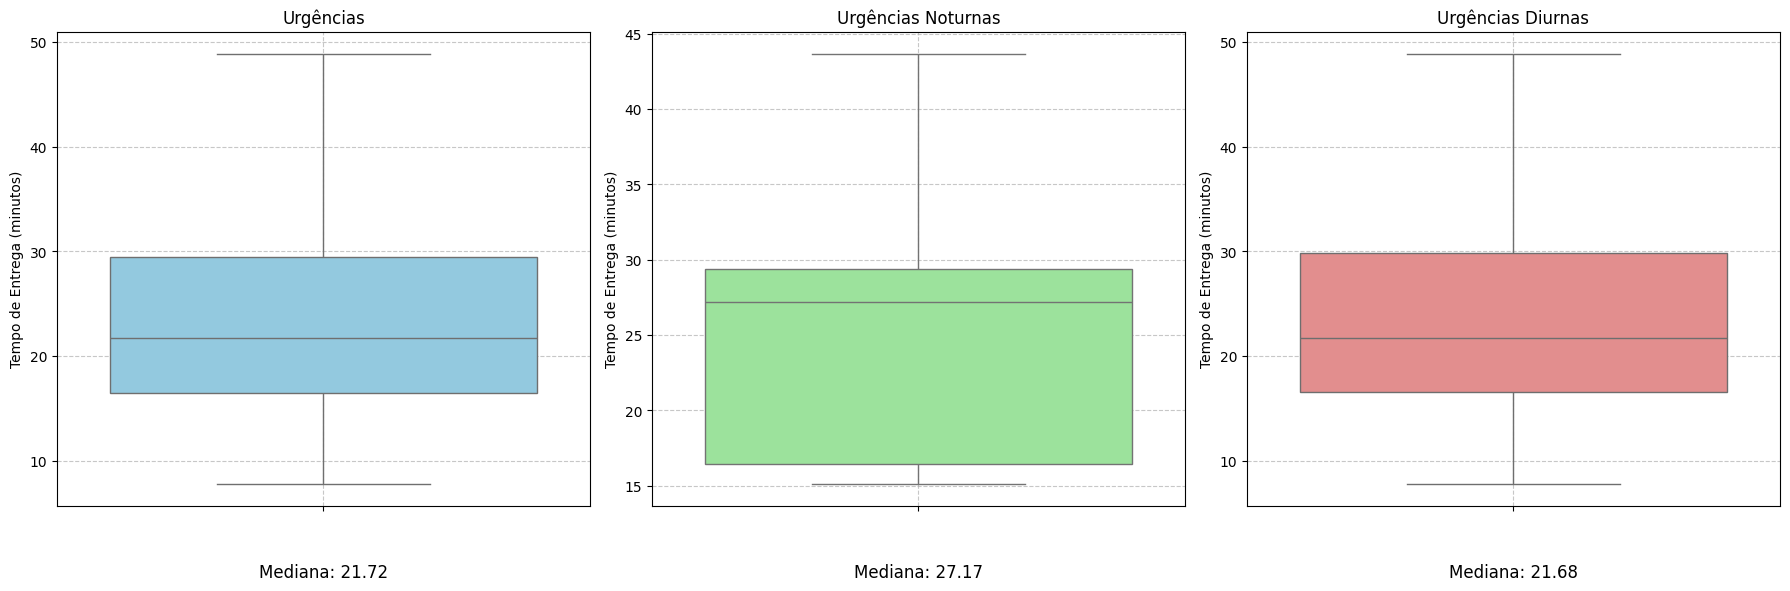

['Mediana do Tempo de entrega de urgências - Diurno e Noturno: 00:21:43',
 'Mediana do Tempo de entrega (Noturno): 00:27:10',
 'Mediana do Tempo de entrega (Diurno): 00:21:43']

In [6]:
# @title Medianas e BoxPlot - total e por período
# ajustando o formato das datas #
# Pontos de atenção #
# Usar o formato - format='%d/%m/%Y\t%H:%M:%S' para datas no formato "01/07/2024 10:16:00"
# Ainda não descobri como arrumar as colunas que tem 0024 - 'Dt ger lote','Dt entr setor' - o python assume que é do século 21. **Essas colunas não são essenciais, acho que não vou procurar essa informação.

tempos_bruto['Dt prescricao'] = pd.to_datetime(tempos_bruto['Dt prescricao'], format='%d/%m/%Y\t%H:%M:%S', errors='coerce')
tempos_bruto['Dt recebimento setor'] = pd.to_datetime(tempos_bruto['Dt recebimento setor'], format='%d/%m/%Y\t%H:%M:%S', errors='coerce')
tempos_bruto['Dt geracao lote'] = pd.to_datetime(tempos_bruto['Dt geracao lote'], format='%d/%m/%Y\t%H:%M:%S', errors='coerce')
tempos_bruto['Dt entrega setor'] = pd.to_datetime(tempos_bruto['Dt entrega setor'], format='%d/%m/%Y\t%H:%M:%S', errors='coerce')

#As horas saem no formato com data (1900-01-01) é necessário criar uma nova coluna sem essa informação com a função .dt.time

tempos_bruto['Hr ger lote'] = pd.to_datetime(tempos_bruto['Hr ger lote'], format='%H:%M:%S', errors='coerce')
tempos_bruto['Hora de geração'] = tempos_bruto['Hr ger lote'].dt.time
tempos_bruto['Hr entr setor'] = pd.to_datetime(tempos_bruto['Hr entr setor'], format='%H:%M:%S', errors='coerce')
tempos_bruto['Hora de Entrega'] = tempos_bruto['Hr entr setor'].dt.time

# Limpar valores vazios - Normalmente saem valores vazios em colunas "sem lote" ou seja Nr sequencia = 0
# ** Provavelmente são itens jogados na conta, preciso verificar o que acontece aqui
# Retirei todas as colunas desnecessárias - 'Dt recebimento setor', 'Dt entr setor', 'Dt ger lote','Hr ger lote','Hr entr setor'
## Como não descobri como arrumar a questão do 0024 e as colunas não são necessárias, retirei - 'Dt ger lote','Dt entr setor'


Tempos_Limpo0 = tempos_bruto.dropna(subset=['Ds classificacao'])
Tempos_Limpo = Tempos_Limpo0.drop(columns=['Dt recebimento setor', 'Dt entr setor', 'Dt ger lote','Hr ger lote','Hr entr setor'])

# Fazendo os cálculos base para MEDIANA #
# Antes de iniciar o calculo é necessário usar o timedelta nas horas.
from datetime import timedelta # Import the timedelta object
Tempos_Limpo['Hora de geração'] = pd.to_timedelta(Tempos_Limpo['Hora de geração'].astype(str))
Tempos_Limpo['Hora de Entrega'] = pd.to_timedelta(Tempos_Limpo['Hora de Entrega'].astype(str))

# Criar a coluna nova com o tempo de entrega.
Tempos_Limpo['Tempo de entrega'] = (Tempos_Limpo['Hora de Entrega'] - Tempos_Limpo['Hora de geração']).apply(lambda x: str(x)[-8:])

# Converter a coluna 'Tempo de entrega' para timedelta64[ns]
Tempos_Limpo['Tempo de entrega'] = pd.to_timedelta(Tempos_Limpo['Tempo de entrega'])

## Filtrando para apenas os itens na Urgência - 'agora' ##

#Selecionar o valor do filtro
valor_desejado = 'Agora'

# Filtrar o dataframe para 'agora'
Tempos_Limpo_Urgencia = Tempos_Limpo[Tempos_Limpo['Ds classificacao'].isin([valor_desejado])].copy()  # Create a copy of the filtered DataFrame

# Converter 'Tempo de entrega' para minutos usando .loc para garantir segurança
Tempos_Limpo_Urgencia.loc[:, 'Tempo de entrega (minutos)'] = Tempos_Limpo_Urgencia['Tempo de entrega'].dt.total_seconds() / 60

#  Remover NaN do 'Tempo de entrega (minutos)'
Tempos_Limpo_Urgencia = Tempos_Limpo_Urgencia.dropna(subset=['Tempo de entrega (minutos)'])

# Calcular a mediana em segundos
mediana_tempo_entrega_segundos = Tempos_Limpo_Urgencia['Tempo de entrega'].dt.total_seconds().median()

# Converter mediana para objeto timedelta
mediana_tempo_entrega_urgencias = timedelta(seconds=mediana_tempo_entrega_segundos)

# Extrair horas, minutos, and segundoss do objeto timedelta
hours = mediana_tempo_entrega_urgencias.seconds // 3600
minutes = (mediana_tempo_entrega_urgencias.seconds % 3600) // 60
seconds = mediana_tempo_entrega_urgencias.seconds % 60

# Filtrar por 'Hora de geração' antes das 06:00:00 ou depois 22:00:00
hora_limite_inferior = time(6, 0, 0)
hora_limite_superior = time(22, 0, 0)

# Colocar 'Hora de geração' no formato timedelta
Tempos_Limpo_Urgencia['Hora de geração'] = pd.to_timedelta(Tempos_Limpo_Urgencia['Hora de geração'].astype(str))

# Extrair a hora da geração, Substituir NaT por 0
hora_geracao_noturno = Tempos_Limpo_Urgencia['Hora de geração'].dt.components.hours.fillna(0)

# Aplicar o filtro usando as horas limite (note que noturno tem | e diurno tem &, o que garante a filtragem correta)
filtered_indices = (hora_geracao_noturno < hora_limite_inferior.hour) | (hora_geracao_noturno > hora_limite_superior.hour)

# Filtrar o dataframe usando uma mascara boleana
Tempos_Limpo_Urgencia_noturno = Tempos_Limpo_Urgencia[filtered_indices]

# Aplicar o filtro para Tempos_Limpo_Urgencia
Tempos_Limpo_Urgencia_noturno = Tempos_Limpo_Urgencia[filtered_indices]

# Calcular o tempo de entrega em segundos
mediana_tempo_entrega_segundos_noturno = Tempos_Limpo_Urgencia_noturno['Tempo de entrega'].dt.total_seconds().median()

# Converter a mediana para objeto timedelta
mediana_tempo_entrega_noturno = timedelta(seconds=mediana_tempo_entrega_segundos_noturno)

# Extrair horas, minutos, and segundoss do objeto timedelta
hours_noturno = mediana_tempo_entrega_noturno.seconds // 3600
minutes_noturno = (mediana_tempo_entrega_noturno.seconds % 3600) // 60
seconds_noturno = mediana_tempo_entrega_noturno.seconds % 60

# Filtrar por 'Hora de geração' antes das 06:00:00 ou depois 22:00:00
hora_limite_inferior = time(6, 0, 0)
hora_limite_superior = time(22, 0, 0)

# Colocar 'Hora de geração' no formato timedelta
Tempos_Limpo_Urgencia['Hora de geração'] = pd.to_timedelta(Tempos_Limpo_Urgencia['Hora de geração'].astype(str))

# Extrair a hora da geração, Substituir NaT por 0
hora_geracao_noturno = Tempos_Limpo_Urgencia['Hora de geração'].dt.components.hours.fillna(0)

# Aplicar o filtro usando as horas limite (note que noturno tem | e diurno tem &, o que garante a filtragem correta)
filtered_indices_business_hours = (hora_geracao_noturno >= hora_limite_inferior.hour) & (hora_geracao_noturno <= hora_limite_superior.hour)

# Filtrar o dataframe usando uma mascara boleana
Tempos_Limpo_Urgencia_Diurno = Tempos_Limpo_Urgencia[filtered_indices_business_hours]

# Calcular o tempo de entrega em segundos
mediana_tempo_entrega_segundos_diurno = Tempos_Limpo_Urgencia_Diurno['Tempo de entrega'].dt.total_seconds().median()

# Converter a mediana para objeto timedelta
mediana_tempo_entrega_segundos_diurno = timedelta(seconds=mediana_tempo_entrega_segundos_diurno)

# Extrair horas, minutos, and segundoss do objeto timedelta
hours_diurno = mediana_tempo_entrega_segundos_diurno.seconds // 3600
minutes_diurno = (mediana_tempo_entrega_segundos_diurno.seconds % 3600) // 60
seconds_business_diurno = mediana_tempo_entrega_segundos_diurno.seconds % 60

mediana_tempo_entrega_Urgencias = [f"Mediana do Tempo de entrega de urgências - Diurno e Noturno: {hours:02}:{minutes:02}:{seconds:02}",
    f"Mediana do Tempo de entrega (Noturno): {hours_noturno:02}:{minutes_noturno:02}:{seconds_noturno:02}",
    f"Mediana do Tempo de entrega (Diurno): {hours_diurno:02}:{minutes_diurno:02}:{seconds_business_diurno:02}"]

  # Dataframes criados #

#1 - tempos_bruto
#2 - Tempos_Limpo0 - Retirado valores nulos do nr sequencia (número do lote)
#3 - Tempos_Limpo - Retirado todas as colunas desnecessárias - 'Dt recebimento setor', 'Dt entr setor', 'Dt ger lote','Hr ger lote','Hr entr setor'
#4 - Tempos_Limpo_Urgencia - Filtrado apenas pro 'Agora'
#5 - Tempos_Limpo_Urgencia_Diurno - Filtrado para 'Agora' e Horário 06 até 22h
#6 - Tempos_Limpo_Urgencia_noturno - Filtrado para 'Agora' e Horário antes 06 ou após 22h

# Calculos criados #

# 1 - mediana_tempo_entrega_urgencias
# 2 - mediana_tempo_entrega_noturno
# 3 - mediana_tempo_entrega_segundos_diurno
# 4 - mediana_tempo_entrega_Urgencias - lista com todos os tempos

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assumindo que os DataFrames já estão carregados

def criar_boxplot_sem_outliers(df, ax, color, title):
    """Cria um box plot sem outliers para o DataFrame fornecido."""
    Q1 = df['Tempo de entrega (minutos)'].quantile(0.25)
    Q3 = df['Tempo de entrega (minutos)'].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    df_sem_outliers = df[
        (df['Tempo de entrega (minutos)'] >= limite_inferior) &
        (df['Tempo de entrega (minutos)'] <= limite_superior)
    ]
    sns.boxplot(y=df_sem_outliers['Tempo de entrega (minutos)'], color=color, ax=ax)
    ax.set_ylabel('Tempo de Entrega (minutos)')
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.7)
    return df_sem_outliers  # Retorna o DataFrame sem outliers para calcular a mediana

# Criando a figura e os subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Criando os box plots e obtendo os DataFrames sem outliers
df1_sem_outliers = criar_boxplot_sem_outliers(Tempos_Limpo_Urgencia, axes[0], 'skyblue', 'Urgências')
df2_sem_outliers = criar_boxplot_sem_outliers(Tempos_Limpo_Urgencia_noturno, axes[1], 'lightgreen', 'Urgências Noturnas')
df3_sem_outliers = criar_boxplot_sem_outliers(Tempos_Limpo_Urgencia_Diurno, axes[2], 'lightcoral', 'Urgências Diurnas')

# Calculando as medianas
medianas = [
    df1_sem_outliers['Tempo de entrega (minutos)'].median(),
    df2_sem_outliers['Tempo de entrega (minutos)'].median(),
    df3_sem_outliers['Tempo de entrega (minutos)'].median()
]

# Exibindo as medianas abaixo dos gráficos
x_pos = np.arange(3) + 0.5  # Posições das medianas no eixo x
for i, mediana in enumerate(medianas):
    axes[i].text(0.5, -0.15, f'Mediana: {mediana:.2f}', transform=axes[i].transAxes, ha='center', fontsize=12)

plt.tight_layout()
plt.show()

mediana_tempo_entrega_Urgencias

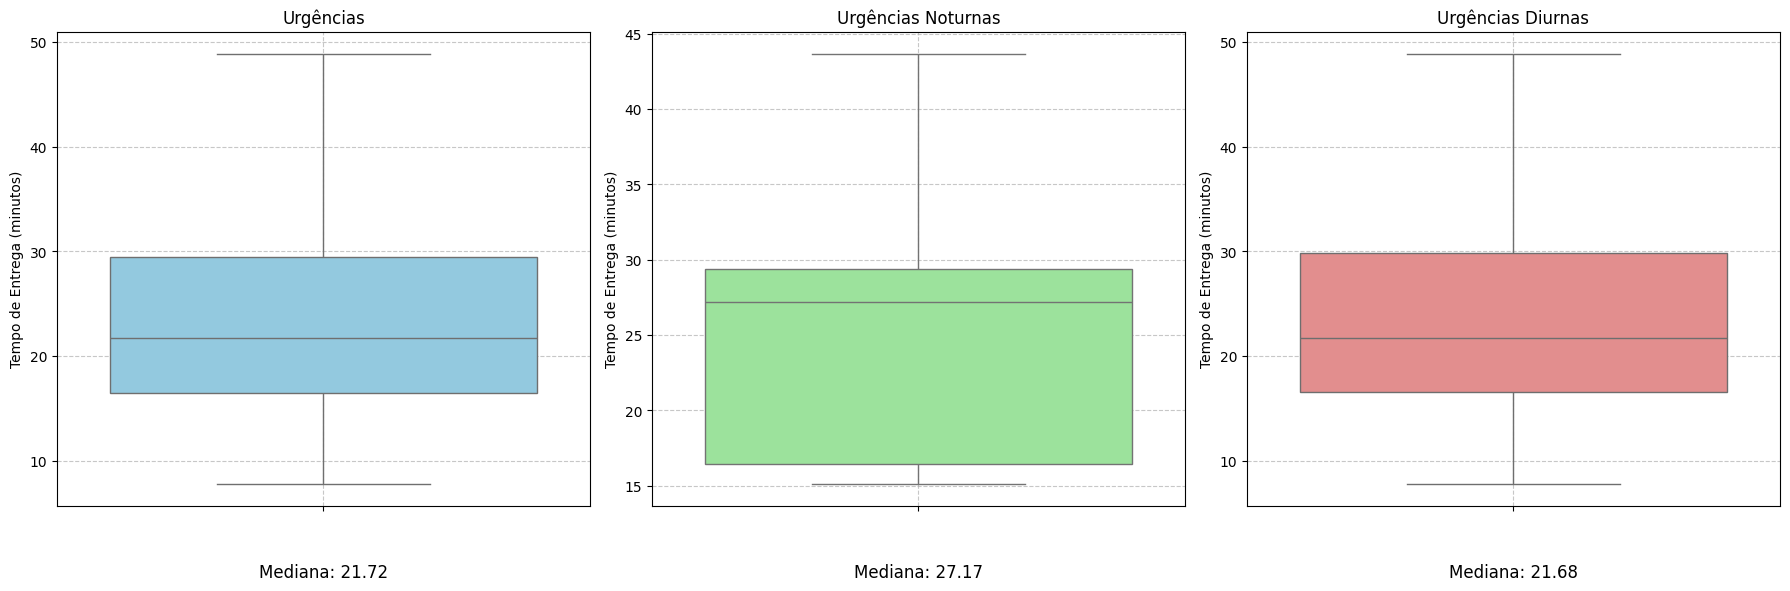

['Mediana do Tempo de entrega de urgências - Diurno e Noturno: 00:21:43',
 'Mediana do Tempo de entrega (Noturno): 00:27:10',
 'Mediana do Tempo de entrega (Diurno): 00:21:43']

In [7]:
# @title Medianas e BoxPlot  Hoje - total e por período
# ajustando o formato das datas #
# Pontos de atenção #
# Usar o formato - format='%d/%m/%Y\t%H:%M:%S' para datas no formato "01/07/2024 10:16:00"
# Ainda não descobri como arrumar as colunas que tem 0024 - 'Dt ger lote','Dt entr setor' - o python assume que é do século 21. **Essas colunas não são essenciais, acho que não vou procurar essa informação.

tempos_bruto1['Dt prescricao'] = pd.to_datetime(tempos_bruto1['Dt prescricao'], format='%d/%m/%Y\t%H:%M:%S', errors='coerce')
tempos_bruto1['Dt recebimento setor'] = pd.to_datetime(tempos_bruto1['Dt recebimento setor'], format='%d/%m/%Y\t%H:%M:%S', errors='coerce')
tempos_bruto1['Dt geracao lote'] = pd.to_datetime(tempos_bruto1['Dt geracao lote'], format='%d/%m/%Y\t%H:%M:%S', errors='coerce')
tempos_bruto1['Dt entrega setor'] = pd.to_datetime(tempos_bruto1['Dt entrega setor'], format='%d/%m/%Y\t%H:%M:%S', errors='coerce')

#As horas saem no formato com data (1900-01-01) é necessário criar uma nova coluna sem essa informação com a função .dt.time

tempos_bruto1['Hr ger lote'] = pd.to_datetime(tempos_bruto1['Hr ger lote'], format='%H:%M:%S', errors='coerce')
tempos_bruto1['Hora de geração'] = tempos_bruto1['Hr ger lote'].dt.time
tempos_bruto1['Hr entr setor'] = pd.to_datetime(tempos_bruto1['Hr entr setor'], format='%H:%M:%S', errors='coerce')
tempos_bruto1['Hora de Entrega'] = tempos_bruto1['Hr entr setor'].dt.time

# Limpar valores vazios - Normalmente saem valores vazios em colunas "sem lote" ou seja Nr sequencia = 0
# ** Provavelmente são itens jogados na conta, preciso verificar o que acontece aqui
# Retirei todas as colunas desnecessárias - 'Dt recebimento setor', 'Dt entr setor', 'Dt ger lote','Hr ger lote','Hr entr setor'
## Como não descobri como arrumar a questão do 0024 e as colunas não são necessárias, retirei - 'Dt ger lote','Dt entr setor'


Tempos_Limpo0 = tempos_bruto1.dropna(subset=['Ds classificacao'])
Tempos_Limpo = Tempos_Limpo0.drop(columns=['Dt recebimento setor', 'Dt entr setor', 'Dt ger lote','Hr ger lote','Hr entr setor'])

# Fazendo os cálculos base para MEDIANA #
# Antes de iniciar o calculo é necessário usar o timedelta nas horas.
from datetime import timedelta # Import the timedelta object
Tempos_Limpo['Hora de geração'] = pd.to_timedelta(Tempos_Limpo['Hora de geração'].astype(str))
Tempos_Limpo['Hora de Entrega'] = pd.to_timedelta(Tempos_Limpo['Hora de Entrega'].astype(str))

# Criar a coluna nova com o tempo de entrega.
Tempos_Limpo['Tempo de entrega'] = (Tempos_Limpo['Hora de Entrega'] - Tempos_Limpo['Hora de geração']).apply(lambda x: str(x)[-8:])

# Converter a coluna 'Tempo de entrega' para timedelta64[ns]
Tempos_Limpo['Tempo de entrega'] = pd.to_timedelta(Tempos_Limpo['Tempo de entrega'])

## Filtrando para apenas os itens na Urgência - 'agora' ##

#Selecionar o valor do filtro
valor_desejado = 'Agora'

# Filtrar o dataframe para 'agora'
Tempos_Limpo_Urgencia = Tempos_Limpo[Tempos_Limpo['Ds classificacao'].isin([valor_desejado])].copy()  # Create a copy of the filtered DataFrame

# Converter 'Tempo de entrega' para minutos usando .loc para garantir segurança
Tempos_Limpo_Urgencia.loc[:, 'Tempo de entrega (minutos)'] = Tempos_Limpo_Urgencia['Tempo de entrega'].dt.total_seconds() / 60

#  Remover NaN do 'Tempo de entrega (minutos)'
Tempos_Limpo_Urgencia = Tempos_Limpo_Urgencia.dropna(subset=['Tempo de entrega (minutos)'])

# Calcular a mediana em segundos
mediana_tempo_entrega_segundos = Tempos_Limpo_Urgencia['Tempo de entrega'].dt.total_seconds().median()

# Converter mediana para objeto timedelta
mediana_tempo_entrega_urgencias = timedelta(seconds=mediana_tempo_entrega_segundos)

# Extrair horas, minutos, and segundoss do objeto timedelta
hours = mediana_tempo_entrega_urgencias.seconds // 3600
minutes = (mediana_tempo_entrega_urgencias.seconds % 3600) // 60
seconds = mediana_tempo_entrega_urgencias.seconds % 60

# Filtrar por 'Hora de geração' antes das 06:00:00 ou depois 22:00:00
hora_limite_inferior = time(6, 0, 0)
hora_limite_superior = time(22, 0, 0)

# Colocar 'Hora de geração' no formato timedelta
Tempos_Limpo_Urgencia['Hora de geração'] = pd.to_timedelta(Tempos_Limpo_Urgencia['Hora de geração'].astype(str))

# Extrair a hora da geração, Substituir NaT por 0
hora_geracao_noturno = Tempos_Limpo_Urgencia['Hora de geração'].dt.components.hours.fillna(0)

# Aplicar o filtro usando as horas limite (note que noturno tem | e diurno tem &, o que garante a filtragem correta)
filtered_indices = (hora_geracao_noturno < hora_limite_inferior.hour) | (hora_geracao_noturno > hora_limite_superior.hour)

# Filtrar o dataframe usando uma mascara boleana
Tempos_Limpo_Urgencia_noturno = Tempos_Limpo_Urgencia[filtered_indices]

# Aplicar o filtro para Tempos_Limpo_Urgencia
Tempos_Limpo_Urgencia_noturno = Tempos_Limpo_Urgencia[filtered_indices]

# Calcular o tempo de entrega em segundos
mediana_tempo_entrega_segundos_noturno = Tempos_Limpo_Urgencia_noturno['Tempo de entrega'].dt.total_seconds().median()

# Converter a mediana para objeto timedelta
mediana_tempo_entrega_noturno = timedelta(seconds=mediana_tempo_entrega_segundos_noturno)

# Extrair horas, minutos, and segundoss do objeto timedelta
hours_noturno = mediana_tempo_entrega_noturno.seconds // 3600
minutes_noturno = (mediana_tempo_entrega_noturno.seconds % 3600) // 60
seconds_noturno = mediana_tempo_entrega_noturno.seconds % 60

# Filtrar por 'Hora de geração' antes das 06:00:00 ou depois 22:00:00
hora_limite_inferior = time(6, 0, 0)
hora_limite_superior = time(22, 0, 0)

# Colocar 'Hora de geração' no formato timedelta
Tempos_Limpo_Urgencia['Hora de geração'] = pd.to_timedelta(Tempos_Limpo_Urgencia['Hora de geração'].astype(str))

# Extrair a hora da geração, Substituir NaT por 0
hora_geracao_noturno = Tempos_Limpo_Urgencia['Hora de geração'].dt.components.hours.fillna(0)

# Aplicar o filtro usando as horas limite (note que noturno tem | e diurno tem &, o que garante a filtragem correta)
filtered_indices_business_hours = (hora_geracao_noturno >= hora_limite_inferior.hour) & (hora_geracao_noturno <= hora_limite_superior.hour)

# Filtrar o dataframe usando uma mascara boleana
Tempos_Limpo_Urgencia_Diurno = Tempos_Limpo_Urgencia[filtered_indices_business_hours]

# Calcular o tempo de entrega em segundos
mediana_tempo_entrega_segundos_diurno = Tempos_Limpo_Urgencia_Diurno['Tempo de entrega'].dt.total_seconds().median()

# Converter a mediana para objeto timedelta
mediana_tempo_entrega_segundos_diurno = timedelta(seconds=mediana_tempo_entrega_segundos_diurno)

# Extrair horas, minutos, and segundoss do objeto timedelta
hours_diurno = mediana_tempo_entrega_segundos_diurno.seconds // 3600
minutes_diurno = (mediana_tempo_entrega_segundos_diurno.seconds % 3600) // 60
seconds_business_diurno = mediana_tempo_entrega_segundos_diurno.seconds % 60

mediana_tempo_entrega_Urgencias = [f"Mediana do Tempo de entrega de urgências - Diurno e Noturno: {hours:02}:{minutes:02}:{seconds:02}",
    f"Mediana do Tempo de entrega (Noturno): {hours_noturno:02}:{minutes_noturno:02}:{seconds_noturno:02}",
    f"Mediana do Tempo de entrega (Diurno): {hours_diurno:02}:{minutes_diurno:02}:{seconds_business_diurno:02}"]

  # Dataframes criados #

#1 - tempos_bruto
#2 - Tempos_Limpo0 - Retirado valores nulos do nr sequencia (número do lote)
#3 - Tempos_Limpo - Retirado todas as colunas desnecessárias - 'Dt recebimento setor', 'Dt entr setor', 'Dt ger lote','Hr ger lote','Hr entr setor'
#4 - Tempos_Limpo_Urgencia - Filtrado apenas pro 'Agora'
#5 - Tempos_Limpo_Urgencia_Diurno - Filtrado para 'Agora' e Horário 06 até 22h
#6 - Tempos_Limpo_Urgencia_noturno - Filtrado para 'Agora' e Horário antes 06 ou após 22h

# Calculos criados #

# 1 - mediana_tempo_entrega_urgencias
# 2 - mediana_tempo_entrega_noturno
# 3 - mediana_tempo_entrega_segundos_diurno
# 4 - mediana_tempo_entrega_Urgencias - lista com todos os tempos

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assumindo que os DataFrames já estão carregados

def criar_boxplot_sem_outliers(df, ax, color, title):
    """Cria um box plot sem outliers para o DataFrame fornecido."""
    Q1 = df['Tempo de entrega (minutos)'].quantile(0.25)
    Q3 = df['Tempo de entrega (minutos)'].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    df_sem_outliers = df[
        (df['Tempo de entrega (minutos)'] >= limite_inferior) &
        (df['Tempo de entrega (minutos)'] <= limite_superior)
    ]
    sns.boxplot(y=df_sem_outliers['Tempo de entrega (minutos)'], color=color, ax=ax)
    ax.set_ylabel('Tempo de Entrega (minutos)')
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.7)
    return df_sem_outliers  # Retorna o DataFrame sem outliers para calcular a mediana

# Criando a figura e os subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Criando os box plots e obtendo os DataFrames sem outliers
df1_sem_outliers = criar_boxplot_sem_outliers(Tempos_Limpo_Urgencia, axes[0], 'skyblue', 'Urgências')
df2_sem_outliers = criar_boxplot_sem_outliers(Tempos_Limpo_Urgencia_noturno, axes[1], 'lightgreen', 'Urgências Noturnas')
df3_sem_outliers = criar_boxplot_sem_outliers(Tempos_Limpo_Urgencia_Diurno, axes[2], 'lightcoral', 'Urgências Diurnas')

# Calculando as medianas
medianas = [
    df1_sem_outliers['Tempo de entrega (minutos)'].median(),
    df2_sem_outliers['Tempo de entrega (minutos)'].median(),
    df3_sem_outliers['Tempo de entrega (minutos)'].median()
]

# Exibindo as medianas abaixo dos gráficos
x_pos = np.arange(3) + 0.5  # Posições das medianas no eixo x
for i, mediana in enumerate(medianas):
    axes[i].text(0.5, -0.15, f'Mediana: {mediana:.2f}', transform=axes[i].transAxes, ha='center', fontsize=12)

plt.tight_layout()
plt.show()

mediana_tempo_entrega_Urgencias

In [8]:
# @title Exportando a nova planilha
# Converter as colunas de data para o tipo datetime
colunas_data = ['Dt prescricao', 'Dt entrega setor', 'Dt recebimento setor', 'Dt geracao lote']
for coluna in colunas_data:
    tempos_bruto[coluna] = pd.to_datetime(tempos_bruto[coluna], errors='coerce')

# Exportar o DataFrame para um arquivo CSV
tempos_bruto.to_csv('outubro.csv', sep=';', encoding='utf-8', quotechar='"', index=False, header=False)

In [21]:
Tempos_Limpo_Urgencia['Dt geracao lote'] = pd.to_datetime(Tempos_Limpo_Urgencia['Dt geracao lote'], format='%d/%m/%Y', errors='coerce')
Tempos_Limpo_Urgencia['Dt entrega setor'] = pd.to_datetime(Tempos_Limpo_Urgencia['Dt entrega setor'], format='%d/%m/%Y', errors='coerce')


tempos_bruto0

/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


Nr atendimento  \
UTI - 6º. Andar ALA C Farmacia UTI - Neuro             273   
                      Farmacia UTI - Neuro             273   
                      Farmacia UTI - Neuro             273   
                      Farmacia UTI - Neuro             273   
                      Farmacia UTI - Neuro             273   
...                                                    ...   
3588069               Pronto Socorro        Pronto Socorro   
3588231               UTI - GERAL              UTI - GERAL   
                      UTI - GERAL              UTI - GERAL   
                      UTI - GERAL              UTI - GERAL   
                      UTI - GERAL              UTI - GERAL   

                                                                               Setor paciente  \
UTI - 6º. Andar ALA C Farmacia UTI - Neuro  Buscopan 10mg - drg. (Brometo de N-Butilesopol...   
                      Farmacia UTI - Neuro  Buscopan 10mg - drg. (Brometo de N-Butilesopol...   
                      Farmacia UTI - Neuro  Buscopan 10mg - drg. (Brometo de N-Butilesopol...   
                      Farmacia UTI - Neuro  Buscopan 10mg - drg. (Brometo de N-Butilesopol...   
                      Farmacia UTI - Neuro  Buscopan 10mg - drg. (Brometo de N-Butilesopol...   
...                                                                                       ...   
3588069               Pronto Socorro                                              Farmácia PS   
3588231               UTI - GERAL                                        Farmácia UTI - Geral   
                      UTI - GERAL                                        Farmácia UTI - Geral   
                      UTI - GERAL                                        Farmácia UTI - Geral   
                      UTI - GERAL                                        Farmácia UTI - Geral   

                                           Setor prescricao  \
UTI - 6º. Andar ALA C Farmacia UTI - Neuro         14433128   
                      Farmacia UTI - Neuro         14433129   
                      Farmacia UTI - Neuro         14434196   
                      Farmacia UTI - Neuro         14434675   
                      Farmacia UTI - Neuro         14435028   
...                                                     ...   
3588069               Pronto Socorro                  71726   
3588231               UTI - GERAL                      6050   
                      UTI - GERAL                     58585   
                      UTI - GERAL                     67684   
                      UTI - GERAL                     67684   

                                                                             Ds local estoque  \
UTI - 6º. Andar ALA C Farmacia UTI - Neuro                                                NaN   
                      Farmacia UTI - Neuro                                                NaN   
                      Farmacia UTI - Neuro                                                NaN   
                      Farmacia UTI - Neuro                                                NaN   
                      Farmacia UTI - Neuro                                                NaN   
...                                                                                       ...   
3588069               Pronto Socorro          Codein 3 mg/mL Susp. Oral - MILILITRO (Codeína)   
3588231               UTI - GERAL                        Ritmonorm 300 mg - cp. (Propafenona)   
                      UTI - GERAL           Somalgin Cardio 81mg - cp. (Acido Acetilsalici...   
                      UTI - GERAL                           Brilinta 90 mg - cp. (Ticagrelor)   
                      UTI - GERAL                           Brilinta 90 mg - cp. (Ticagrelor)   

                                           Cd material Ds material  \
UTI - 6º. Andar ALA C Farmacia UTI - Neuro         NaN         NaN   
                      Farmacia UTI - Neuro         NaN         NaN   
  

In [19]:
# Verifique o formato dos dados em 'Dt geracao lote'
print(tempos_bruto['Dt geracao lote'].head())

# Se o formato for 'dd/mm/yyyy hh:mm:ss', use:
tempos_bruto['Dt geracao lote'] = pd.to_datetime(tempos_bruto['Dt geracao lote'], format='%d/%m/%Y %H:%M:%S', errors='coerce')

tempos_bruto

0   NaT
1   NaT
2   NaT
3   NaT
4   NaT
Name: Dt geracao lote, dtype: datetime64[ns]


,Nr atendimento,Setor paciente,Setor prescricao,Ds local estoque,Cd material,Ds material,Nr sequencia,Dt prescricao,Dt entrega setor,Dt recebimento setor,Dt geracao lote,Ds classificacao,Dt ger lote,Hr ger lote,Dt entr setor,Hr entr setor,Usuario entrega,Hora de geração,Hora de Entrega,Data da Prescricao
0,273,Buscopan 10mg - drg. (Brometo de N-Butilesopol...,14433128,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,GCarneiro,NaT,07:31:29,NaT,11:01:16,NaT,NaT,NaT
1,273,Buscopan 10mg - drg. (Brometo de N-Butilesopol...,14433129,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,JVieiraBF,NaT,13:46:06,NaT,11:01:16,NaT,NaT,NaT
2,273,Buscopan 10mg - drg. (Brometo de N-Butilesopol...,14434196,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,VBSantos,NaT,19:45:08,NaT,17:19:21,NaT,NaT,NaT
3,273,Buscopan 10mg - drg. (Brometo de N-Butilesopol...,14434675,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,GCarneiro,NaT,07:31:29,NaT,22:51:13,NaT,NaT,NaT
4,273,Buscopan 10mg - drg. (Brometo de N-Butilesopol...,14435028,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,FSLevino,NaT,12:49:09,NaT,06:17:17,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16373,3588069,Pronto Socorro,Pronto Socorro,Farmácia PS,71726,Codein 3 mg/mL Susp. Oral - MILILITRO (Codeína),14472978,NaT,NaT,NaT,NaT,Agora,17/10/0024,1900-01-01 20:08:54,17/10/0024,1900-01-01 21:20:19,RSilvaO,20:08:54,21:20:19,NaT
16374,3588231,UTI - GERAL,UTI - GERAL,Farmácia UTI - Geral,6050,Ritmonorm 300 mg - cp. (Propafenona),14473261,NaT,NaT,NaT,NaT,Normal,17/10/0024,1900-01-01 22:44:25,18/10/0024,1900-01-01 07:18:35,RJDSouza,22:44:25,07:18:35,NaT
16375,3588231,UTI - GERAL,UTI - GERAL,Farmácia UTI - Geral,58585,Somalgin Cardio 81mg - cp. (Acido Acetilsalici...,14473261,NaT,NaT,NaT,NaT,Normal,17/10/0024,1900-01-01 22:44:25,18/10/0024,1900-01-01 07:18:35,RJDSouza,22:44:25,07:18:35,NaT
16376,3588231,UTI - GERAL,UTI - GERAL,Farmácia UTI - Geral,67684,Brilinta 90 mg - cp. (Ticagrelor),14473261,NaT,NaT,NaT,NaT,Normal,17/10/0024,1900-01-01 22:44:25,18/10/0024,1900-01-01 07:18:35,RJDSouza,22:44:25,07:18:35,NaT


In [9]:
import pandas as pd

# Converter a coluna 'Dt prescricao' para datetime, se ainda não estiver
tempos_bruto['Dt prescricao'] = pd.to_datetime(tempos_bruto['Dt prescricao'], format='%d/%m/%Y\t%H:%M:%S', errors='coerce')

# Criar uma nova coluna apenas com a data da prescrição
tempos_bruto['Data da Prescricao'] = tempos_bruto['Dt prescricao'].dt.date

# Agrupar por data da prescrição e calcular a mediana do tempo de entrega
mediana_por_dia = tempos_bruto.groupby('Data da Prescricao')['Tempo de entrega'].median()

# Exibir a mediana por dia
print(mediana_por_dia)

KeyError: 'Column not found: Tempo de entrega'